In [139]:
import numpy as np
import pylab as plt

from scipy.linalg import sqrtm, solve
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from scipy.stats import invwishart
from numpy.polynomial import legendre
import time

import healpy as hp

## Spectral basis functions

In [11]:
def basis_edges_poly(nu, nu_ref=300., params=None):
    """
    Shape (Nfreqs, Nmodes)
    """
    x = nu / nu_ref
    return np.array(
                [ x**-2.5,
                  x**-2.5 * np.log(x),
                  x**-2.5 * np.log(x)**2.,
                  x**-4.5,
                  x**-2.]
        ).T


def basis_powerlaw(nu, nu_ref=300., params=[-2.7,]):
    """
    Shape (Nfreqs, Nmodes)
    """
    x = nu / nu_ref
    beta = params[0]
    return np.array([x**beta,]).T


def basis_poly_legendre(nu, nu_ref=300., params=[5,]):
    """
    Shape (Nfreqs, Nmodes)
    """
    # Generate Legendre functions
    poly_order = params[0]
    lf = legendre(poly_order)
    
    # Normalise freqs. on interval [-1, +1]
    pass

## Sky model projection function

In [60]:
def sky_model(amps, proj_matrix):
    """
    Compute a full sky model given a set of parameters.
    
    Parameters:
        amps (array_like):
            Amplitudes for the basis functions in each pixel. 
            Expected shape: `(Npix, Nmodes)`.
        proj_matrix (array_like):
            Projection operator for each pixel, which goes 
            from parameters to temperature values at each 
            frequency. Shape: `(Nfreqs, Nmodes)`.
    
    Returns:
        sky_model (array_like):
            Array of sky maps at each frequency, of shape `(Nfreqs, Npix)`.
    """
    # Initialise sky model array
    Npix = amps.shape[0]
    Nfreqs = proj_matrix.shape[0]
    sky_map = np.zeros((Nfreqs, Npix))
    
    # Multiply amplitudes by projection operator to get per-freq. maps
    sky_map[:,:] = proj_matrix @ amps.T
    return sky_map

## Sampling functions

In [659]:
def inversion_sample_beta(freqs, data, amps, inv_noise_var, beta_range=(-3.2, -2.2),
                          nu_ref=300., grid_points=400, 
                          interp_kind='linear', realisations=1, comm=None):
    """
    Use inversion sampling to draw samples of the power law beta parameter.
    """
    # Set up MPI if enabled
    myid = 0
    nworkers = 1
    if comm is not None:
        myid = comm.Get_rank()
        nworkers = comm.Get_size()
        
    # Calculate likelihood values as a function of beta
    beta_min, beta_max = beta_range
    beta_vals = np.linspace(beta_min, beta_max, grid_points)
    
    # Empty results array
    Npix = inv_noise_var.shape[1]
    beta_samples = np.zeros((realisations, Npix))
    
    def loglike(beta, amps_p, inv_noise_var_p, data_p):
        proj = basis_powerlaw(freqs, nu_ref=nu_ref, params=[beta,])
        model_p = proj @ amps_p #sky_model(amps_p, proj)
        return -0.5 * np.sum(inv_noise_var_p * (data_p - model_p)**2.)
    
    # Loop over pixels
    for p in range(Npix):
        if p % 1000 == 0:
            print("Pixel %d / %d" % (p, Npix))
    
        # Data and model values in this pixel
        amps_p = amps[p,:]
        inv_noise_var_p = inv_noise_var[:,p]
        data_p = data[:,p]
        
        # Calculate log likelihood vs beta
        logL = np.array([loglike(beta, amps_p, inv_noise_var_p, data_p) 
                         for beta in beta_vals])
        
        # Remove common factor since it will be normalised away anyway
        logL0 = np.max(logL)
        likefn = np.exp(logL - logL0)

        # Calculate CDF
        cdf = cumulative_trapezoid(likefn, beta_vals, initial=0.)
        cdf /= cdf[-1] # normalise to interval [0, 1]
    
        # Build interpolator
        interp_cdf = interp1d(cdf, beta_vals, kind=interp_kind)
    
        # Draw uniform random sample(s) and map to distribution for beta using CDF
        uvals = np.random.uniform(size=realisations)
        beta_samples[:,p] = np.array([interp_cdf(u) for u in uvals])
        
    return beta_samples

In [166]:
def sample_covmat(amps):
    """
    Draw samples of covariance matrix for a set of samples, e.g. of spectral 
    basis function coefficients. This draws from an inverse Wishart distribution.
    
    Parameters:
        amps (array_like):
            Amplitudes for the spectral basis functions in each pixel. 
            Expected shape: `(Npix, Nmodes)`.
    
    Returns:
        cov (array_like):
            Sample of the covariance matrix of the foreground coefficients.
            Shape: `(Nmodes, Nmodes)`.
    """
    Npix, Nmodes = amps.shape

    p = Nmodes # Dimension of the scale matrix
    nu = Npix - p - 1 # Degrees of freedom, must be greater than or equal to dimension of the scale matrix
    assert nu >= p, "Degrees of freedom must be greater than or equal to the dimension of the scale matrix."

    # Compute the scale matrix (uncentred, unnormalised covariance)
    Psi = np.zeros((p, p))
    for i in range(Npix):
        Psi += np.outer(amps[i, :], amps[i, :])

    # Draw a sample from the inverse Wishart distribution
    cov_sample = invwishart.rvs(df=nu, scale=Psi)
    return cov_sample

In [606]:
def linear_solve_pixel(freqs, data, proj_fn, proj_params, delta_gains, inv_noise_var, 
                       Sinv, realisations=1, nu_ref=300., comm=None):
    """
    Solve Gaussian Constrained Realisation system for spectral parameters 
    in each pixel.
    
    Parameters:
        freqs (array_like):
            Frequencies that the data maps are evaluated at.
        data (array_like):
            Healpix maps for each frequency band, of shape `(Nfreqs, Npix)`.
        proj_fn (func):
            Function that returns a projection operator for each pixel.
        proj_params (array_like):
            Array of (non-coefficient) parameters to pass to `proj_fn`. 
            Has shape `(Npix, Nparams)`.
        delta_gains (array_like):
            Fractional gain fluctuation for each band. Has shape `(Nfreqs,)`.
        inv_noise_var (array_like):
            The inverse of the noise variance per frequency channel, per 
            pixel. Expected shape: `(Nfreqs, Npix)`.
        Sinv (array_like):
            Inverse of the prior covariance matrix for the spectral 
            parameters, assumed to be the same for all pixels.
        realisations (int):
            Number of realisations of the GCR solution to return.
        nu_ref (float):
            Reference frequency, in MHz.
        comm (MPI communicator):
            MPI Communicator object.
    
    Returns:
        g (array_like):
            Array of sampled per-frequency gain values. 
            Shape: `(realisations, Nfreqs)`.
    """
    # Set up MPI if enabled
    myid = 0
    nworkers = 1
    if comm is not None:
        myid = comm.Get_rank()
        nworkers = comm.Get_size()
    
    # Get matrix shapes
    proj = proj_fn(freqs, nu_ref=nu_ref, params=proj_params[0,:]) # test run: first pixel only
    Nfreqs, Nmodes = proj.shape
    Npix = inv_noise_var.shape[1]
    
    # Empty results matrix
    s = np.zeros((realisations, Npix, Nmodes))
    
    # Loop over pixels
    for p in range(Npix):
        
        # Basic status report
        if p % 5000 == 0:
            print("%6d / %6d" % (p, Npix))
        
        # MPI worker assignment
        if p % nworkers != myid:
            continue
        
        # Update projection matrix
        proj = proj_fn(freqs, params=proj_params[p,:])
        
        # LHS matrix: (S^-1 + A^T N^-1 A)
        # proj_matrix has shape (Nfreqs, Nmodes)
        # Sinv has shape (Nmodes, Nmodes)
        # Ninv has shape (Nfreqs, Nfreqs)
        Ninv = np.diag(inv_noise_var[:,p])
        lhs_op = Sinv + proj.T @ Ninv @ proj

        for i in range(realisations):
            # Draw unit Gaussian random numbers
            omega_n = np.random.randn(Nfreqs)
            omega_s = np.random.randn(Nmodes)

            # RHS vector
            # data has shape (Nfreqs,)
            rhs = proj.T @ Ninv @ data[:,p] \
                + proj.T @ sqrtm(Ninv) @ omega_n \
                + sqrtm(Sinv) @ omega_s

            # Do linear solve for symmetric matrix
            s[i,p,:] = solve(lhs_op, rhs, assume_a='sym')
    
    # FIXME: Need to do MPI communication
    total_s = np.zeros_like(s)
    if comm is not None:
        comm.Allreduce(s.flatten(), total_s, op=MPI_SUM)
        total_s = total_s.reshape(s.shape)
    else:
        total_s = s
    return total_s


def linear_solve_gain(data, amps, proj_matrix, inv_noise_var, Sinv, realisations=1):
    """
    Solve Gaussian Constrained Realisation system for gain parameters 
    that are common to all pixels at a given frequency (i.e. an overall 
    multiplicative factor per band).
    
    Note that this solves for the gain fractional perturbations, delta g, 
    where we have defined gain = gbar (1 + delta g), and gbar = 1.
    
    Parameters:
        data (array_like):
            Healpix maps for each frequency band, of shape `(Nfreqs, Npix)`.
        amps (array_like):
            Amplitudes for the spectral basis functions in each pixel. 
            Expected shape: `(Npix, Nmodes)`.
        proj_matrix (array_like):
            Projection operator to go from parameters to a temperature 
            at each frequency. This operator is assumed to be the same 
            for each pixel.
        inv_noise_var (array_like):
            The inverse of the noise variance per frequency channel, per 
            pixel. Expected shape: `(Nfreqs, Npix)`.
        Sinv (array_like):
            Inverse of the prior covariance matrix for the per-frequency 
            channel gains.
        realisations (int):
            Number of realisations of the GCR solution to return.
    
    Returns:
        g (array_like):
            Array of sampled per-frequency gain values. 
            Shape: `(realisations, Nfreqs)`.
    """
    Nfreqs, Npix = data.shape
    
    # Get sky model
    model = sky_model(amps, proj_matrix) # (Nfreqs, Npix)
    
    # Construct LHS matrix. The gains are per-band and the noise covariance 
    # is assumed to be diagonal, so the A^T N^-1 A term is diagonal in frequency
    lhs_op = Sinv + np.diag( np.sum(inv_noise_var * model**2., axis=1) )
    
    # Empty results matrix
    g = np.zeros((realisations, Nfreqs))
    
    # Loop over requested realisations
    for i in range(realisations):
        # Draw unit Gaussian random numbers
        omega_n = np.random.randn(*model.shape) # same size as data!
        omega_g = np.random.randn(Nfreqs)

        # RHS vector
        # This works with the residual, as we model the data as:
        # data = gbar (1 + delta g) sky_model and gbar = 1
        # So: resid = data - sky_model = delta_g sky_model
        rhs = np.sum(
                     model * (inv_noise_var * (data - model)
                              + np.sqrt(inv_noise_var) * omega_n),
                     axis=1
                    ) \
            + sqrtm(Sinv) @ omega_g

        # Do linear solve for symmetric matrix
        g[i] = solve(lhs_op, rhs, assume_a='sym')
        
    return g

## Load data files

In [220]:
ls ../../data

DRAO_10MHz_hpx_r7.fits
Dwingeloo_Kelvins_1_256.fits
EDA2_159MHz_I_wPrior_HPXbin.fits
EDA2prior159_Haslam408_SI_HPXbin.fits
haslam408_ds_Remazeilles2014.fits
healpix-all-sky-rav-wsclean-err-35.fits
healpix-all-sky-rav-wsclean-err-38.fits
healpix-all-sky-rav-wsclean-err-40.fits
healpix-all-sky-rav-wsclean-err-45.fits
healpix-all-sky-rav-wsclean-err-50.fits
healpix-all-sky-rav-wsclean-err-60.fits
healpix-all-sky-rav-wsclean-err-70.fits
healpix-all-sky-rav-wsclean-err-74.fits
healpix-all-sky-rav-wsclean-err-80.fits
healpix-all-sky-rav-wsclean-map-35.fits
healpix-all-sky-rav-wsclean-map-38.fits
healpix-all-sky-rav-wsclean-map-40.fits
healpix-all-sky-rav-wsclean-map-45.fits
healpix-all-sky-rav-wsclean-map-50.fits
healpix-all-sky-rav-wsclean-map-60.fits
healpix-all-sky-rav-wsclean-map-70.fits
healpix-all-sky-rav-wsclean-map-74.fits
healpix-all-sky-rav-wsclean-map-80.fits
lambda_DRAO_22MHz_1_256.fits
lambda_landecker_wielebinski_150MHz_hpx_r8.fits
lambda_Parkes_85MHz_1_64.fits
MAIPU_MU_1_64.fi

In [520]:
def load_and_mask_healpix_map(fname, nside_out=64, mask_val=None, 
                              smooth_fwhm=5., grow_mask=None, 
                              udgrade_pess=False, udgrade_power=None,
                              rotate=None):
    """
    Load a Healpix map from a file, apply a smoothing, pad the mask 
    edges, and degrade resolution.
    
    Parameters:
        fname (str):
            Path to the .fits file containing the Healpix map.
        nside_out (int):
            Healpix NSIDE to use for the output map.
        mask_val (float or str):
            The pixel value that should be interpreted as a mask. 
            By default this will use the Healpix UNSEEN special 
            value. If set to 'min', the minimum value of the map 
            will be used. Otherwise, the specified value will be used.
        smooth_fwhm (float):
            FWHM (in degrees) of the Gaussian smoothing to apply. For 
            maps already convolved with a beam of FWHM `theta`, you 
            should set `smooth_fwhm = sqrt(desired_fwhm^2 - theta^2)` 
            to account for the existing smoothing.
        grow_mask (float):
            At each masked pixel, extend the mask around it by a 
            circular mask of radius `grow_mask` (in degrees). This 
            is useful for masking out pixels adjacent to the mask.
        udgrade_pess (bool):
            xx
        udgrade_power (float):
            xx
        rotate (list of str):
            xx
    
    Returns:
        out_map (array_like):
            A Healpix map that has had the various processing steps 
            above applied.
        mask_idxs (array_like):
            Array of integer pixel indices of masked pixels.
    """
    # Read map from file
    input_map = hp.read_map(fname)
    nside_in = hp.npix2nside(input_map.size)
    
    if rotate is not None:
        rot = hp.Rotator(coord=rotate)
        input_map = rot.rotate_map_pixel(input_map)

    # Re-flag masked regions
    if mask_val is None:
        mask_val = hp.UNSEEN
    if mask_val == 'min':
        mask_val = input_map.min()
    
    # Check for infs and NaNs
    #print("NAN:", np.where(np.isnan(input_map)))
    #print("INF:", np.where(np.isinf(input_map)))
    
    # Get mask idxs and update to use standard Healpix mask value
    input_map[np.where(np.isnan(input_map))] = hp.UNSEEN # replace NaNs
    mask_idxs = np.where(input_map == mask_val)[0]
    input_map[mask_idxs] = hp.UNSEEN
    
    # Copy map
    new_map = input_map.copy()
    
    # Expand mask around existing mask
    if grow_mask is not None:
        
        # Loop over existing mask idxs
        for i in mask_idxs:
            pix_idxs = hp.query_disc(nside=nside_in, 
                                     vec=hp.pix2vec(nside=nside_in, ipix=i), 
                                     radius=np.deg2rad(smooth_fwhm), 
                                     inclusive=True)
            new_map[pix_idxs] = hp.UNSEEN
    
    # Degrade map to new resolution and get mask indices
    out_map = hp.ud_grade(map_in=new_map,
                          nside_out=nside_out,
                          pess=udgrade_pess,
                          power=udgrade_power)
    mask_idxs = np.where(out_map == hp.UNSEEN)[0]

    return out_map, mask_idxs
    
#drao_022_map = hp.read_map("../../data/lambda_DRAO_22MHz_1_256.fits")
#sm_drao_022_map = hp.smoothing(drao_022_map, fwhm=np.deg2rad(5.), pol=False, use_pixel_weights=True)

In [670]:
nside_out = 32

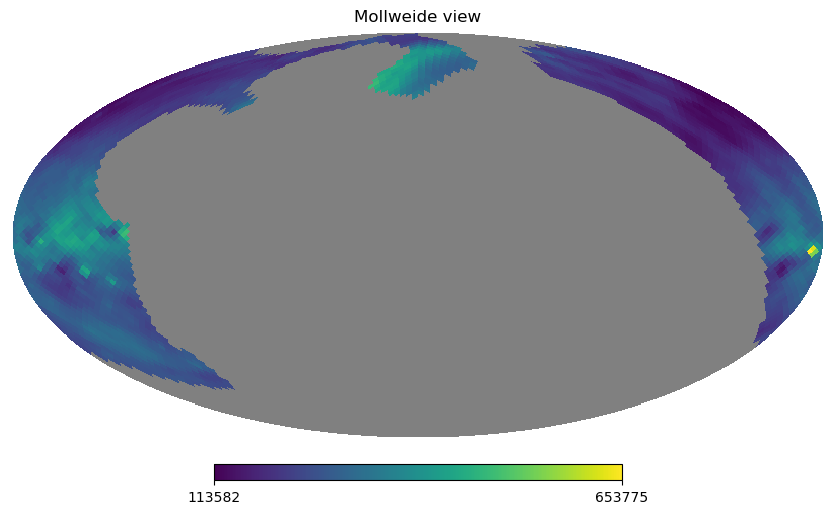

In [671]:
# DRAO 10 MHz map (http://adsabs.harvard.edu/abs/1976MNRAS.177..601C)
drao_010_map, drao_010_mask = load_and_mask_healpix_map(
                                    fname="../../data/DRAO_10MHz_hpx_r7.fits", 
                                    nside_out=nside_out, 
                                    mask_val='min', 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None)

# Noise rms (expected to be 1.4e-3 times the sky temperature; see Sect. 4 of data paper)
drao_010_rms = 1.4e-3 * drao_010_map

hp.mollview(drao_010_map)

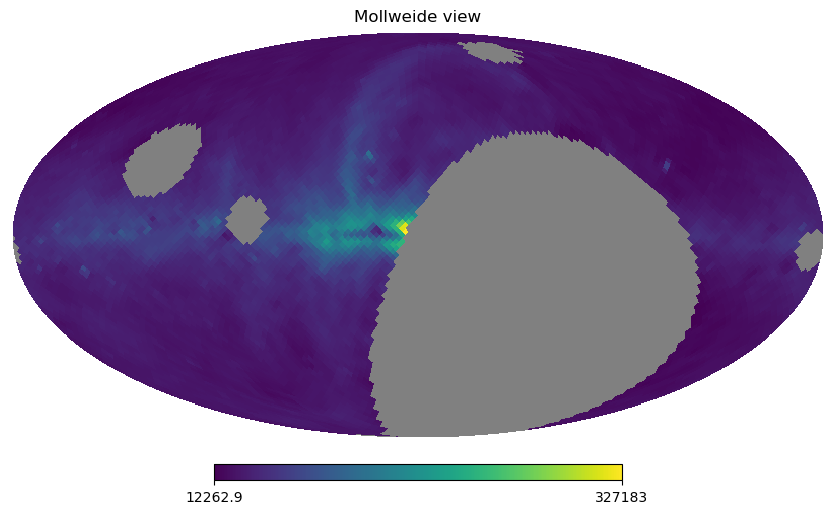

In [672]:
drao_022_map, drao_022_mask = load_and_mask_healpix_map(
                                    fname="../../data/lambda_DRAO_22MHz_1_256.fits", 
                                    nside_out=nside_out, 
                                    mask_val='min', 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None)
hp.mollview(drao_022_map)

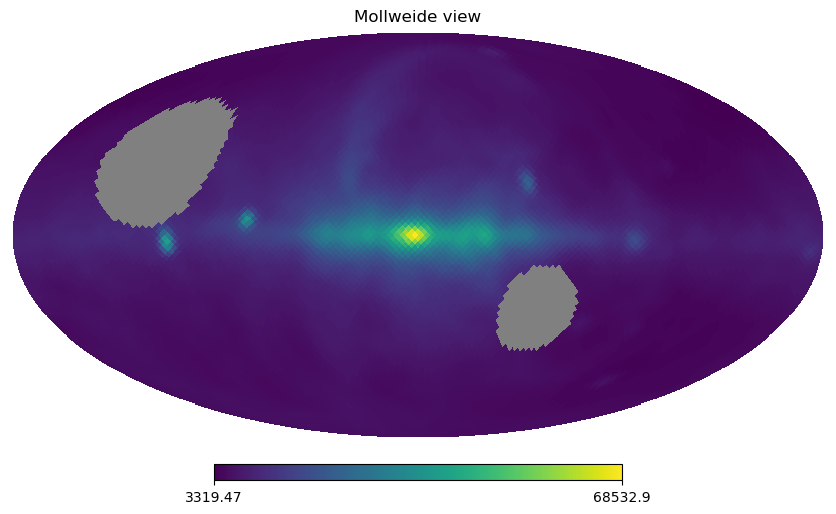

In [673]:
maipu_045_map, maipu_045_mask = load_and_mask_healpix_map(
                                    fname="../../data/MAIPU_MU_1_64.fits", 
                                    nside_out=nside_out, 
                                    mask_val='min', 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None)
hp.mollview(maipu_045_map)

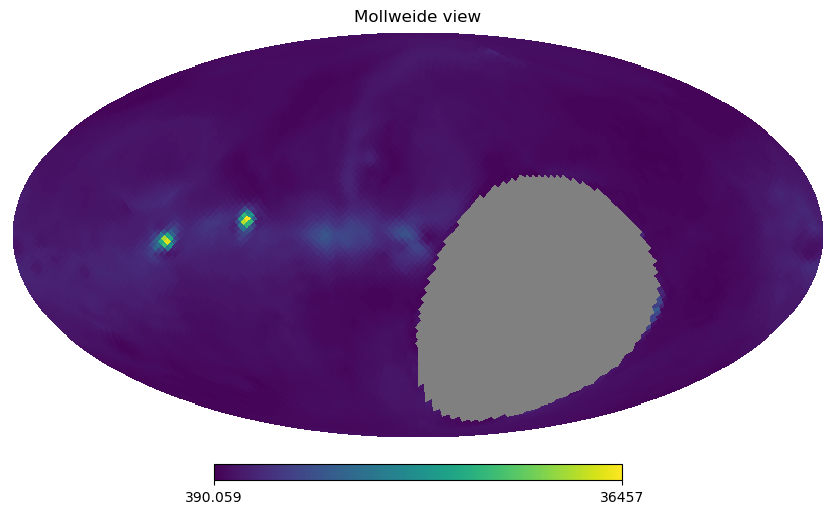

In [674]:
_map, _mask = load_and_mask_healpix_map(
                                    fname="../../data/%s" % "healpix-all-sky-rav-wsclean-err-35.fits", 
                                    nside_out=nside_out, 
                                    mask_val='min', 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None,
                                    rotate=['C', 'G'])
hp.mollview(_map)

healpix-all-sky-rav-wsclean-map-35.fits
healpix-all-sky-rav-wsclean-map-38.fits
healpix-all-sky-rav-wsclean-map-40.fits
healpix-all-sky-rav-wsclean-map-45.fits
healpix-all-sky-rav-wsclean-map-50.fits
healpix-all-sky-rav-wsclean-map-60.fits
healpix-all-sky-rav-wsclean-map-70.fits
healpix-all-sky-rav-wsclean-map-74.fits
healpix-all-sky-rav-wsclean-map-80.fits


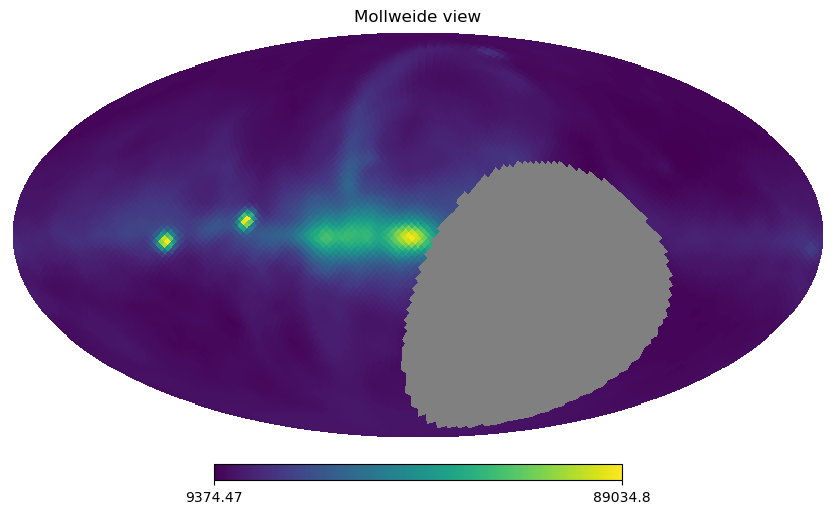

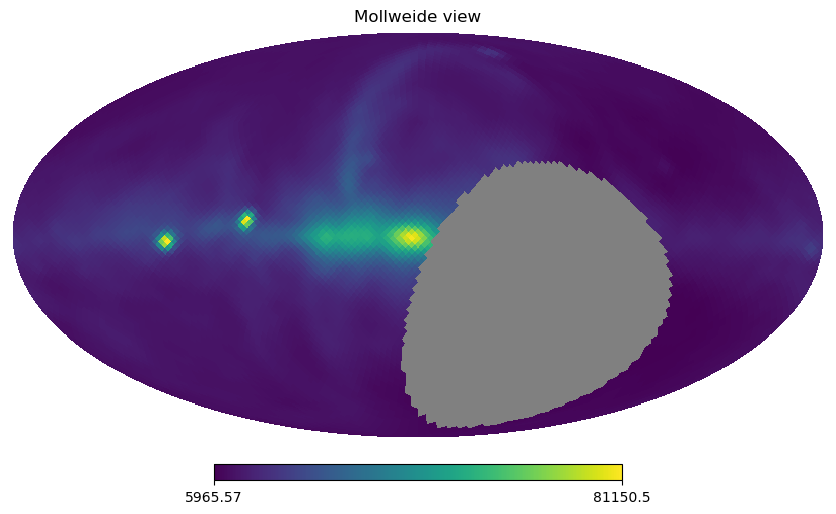

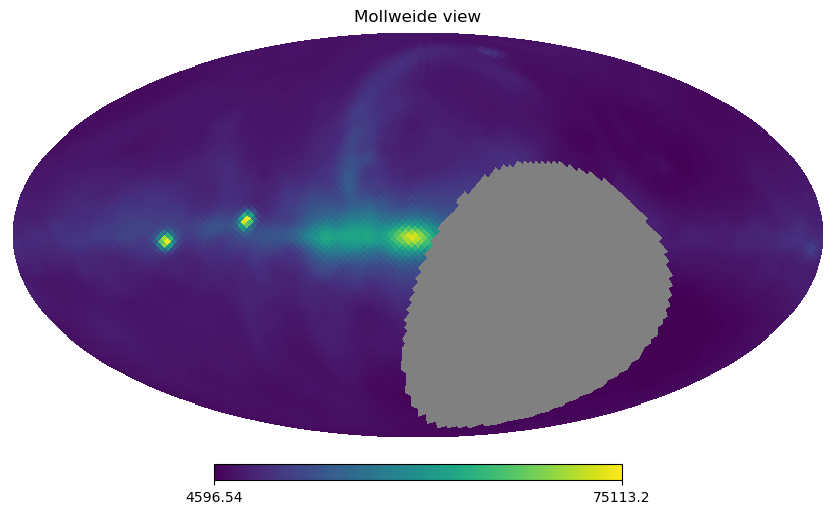

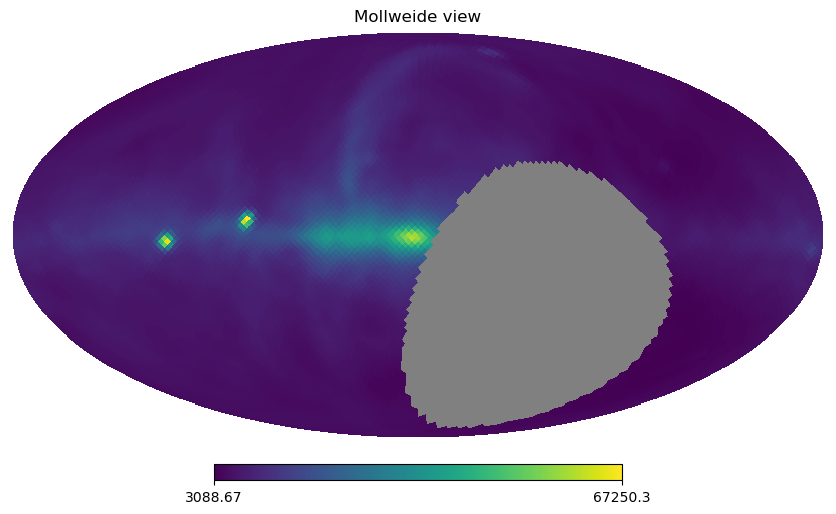

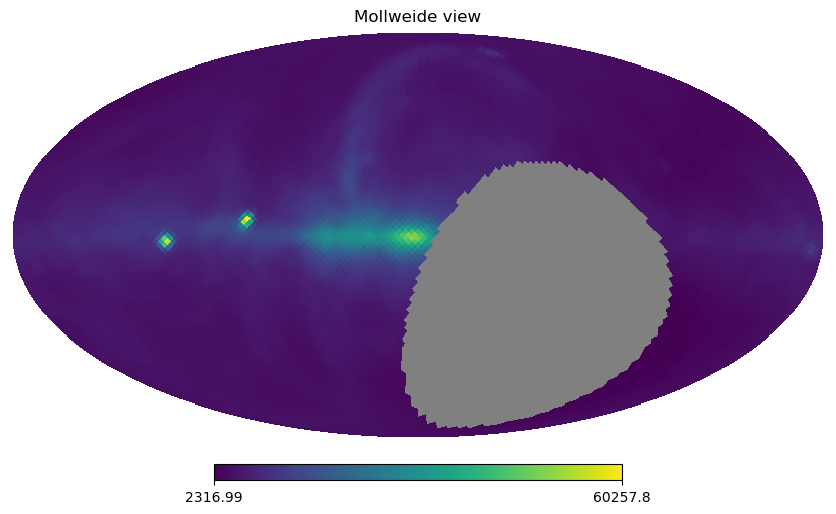

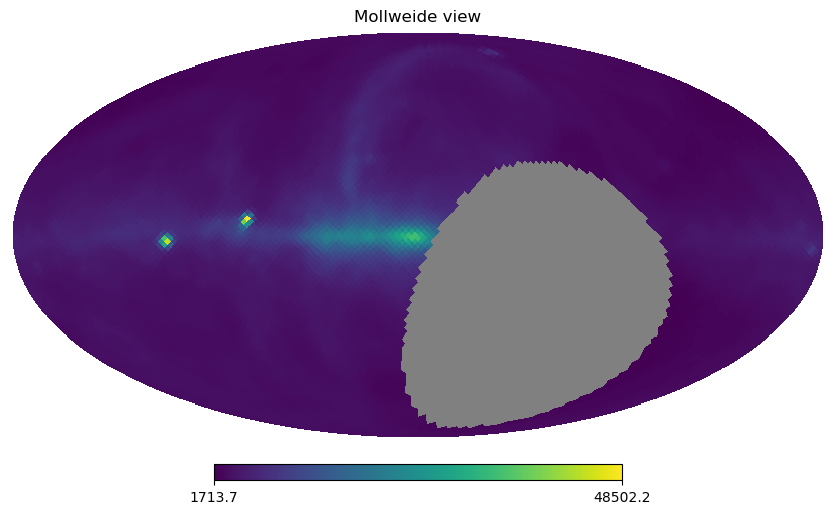

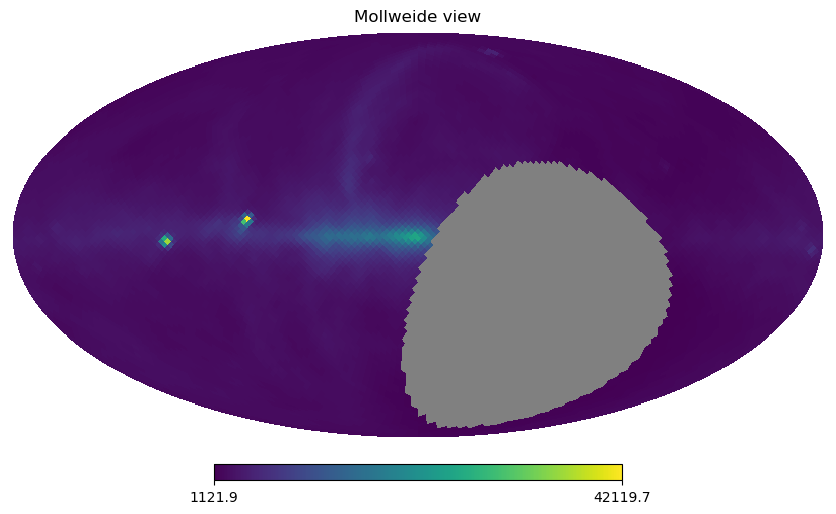

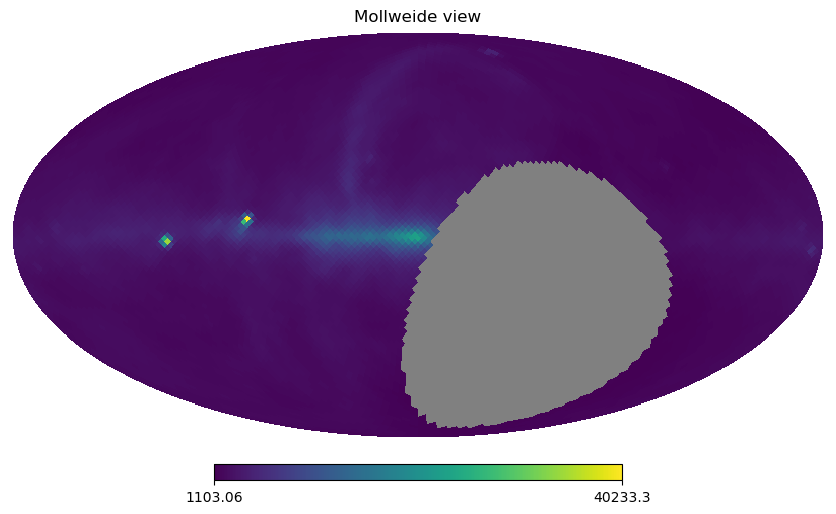

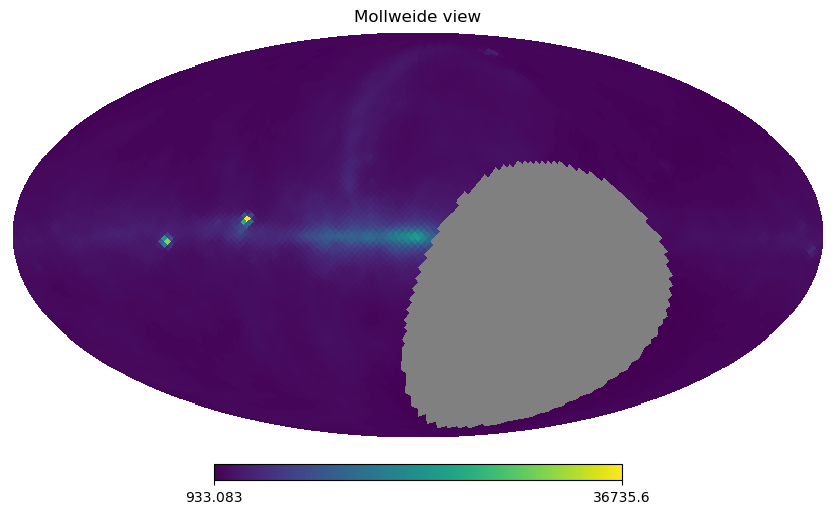

In [675]:
# LWA1 radio maps: https://lambda.gsfc.nasa.gov/product/foreground/fg_lwa1_radio_maps_info.html

lwa1_freqs = [35, 38, 40, 45, 50, 60, 70, 74, 80]
lwa1_maps = [0 for ff in lwa1_freqs]
lwa1_rms = [0 for ff in lwa1_freqs]
lwa1_masks = [0 for ff in lwa1_freqs]

for i, ff in enumerate(lwa1_freqs):
    fname = "healpix-all-sky-rav-wsclean-map-%d.fits" % ff
    fname_rms = "healpix-all-sky-rav-wsclean-err-%d.fits" % ff
    print(fname)
    
    _map, _mask = load_and_mask_healpix_map(
                                    fname="../../data/%s" % fname, 
                                    nside_out=nside_out, 
                                    mask_val=None, 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None,
                                    rotate=['C', 'G'])
    
    _rms, _mask2 = load_and_mask_healpix_map(
                                    fname="../../data/%s" % fname_rms, 
                                    nside_out=nside_out, 
                                    mask_val=None, 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None, # FIXME: Should add in quadrature
                                    rotate=['C', 'G'])
    
    
    lwa1_maps[i] = _map
    lwa1_rms[i] = _rms
    lwa1_masks[i] = _mask
    hp.mollview(lwa1_maps[i])

In [676]:
"""
eda2_159_map, eda2_159_mask = load_and_mask_healpix_map(
                                    fname="../../data/EDA2_159MHz_I_wPrior_HPXbin.fits", 
                                    #fname="../../data/EDA2prior159_Haslam408_SI_HPXbin.fits",
                                    nside_out=nside_out, 
                                    mask_val=None, 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None)
rot = hp.Rotator(coord=['C','G']) # 'C' is equatorial, 'G' is Galactic
eda2_159_map = rot.rotate_map_alms(eda2_159_map)
hp.mollview(np.log10(eda2_159_map))
"""
pass

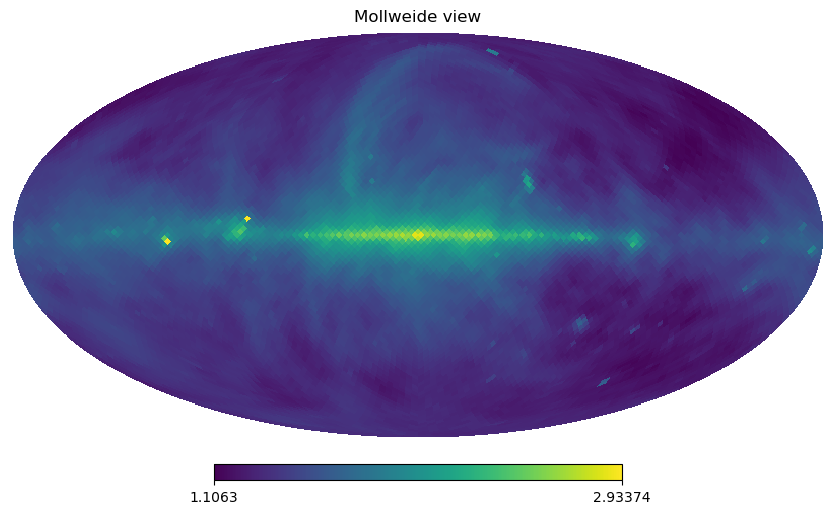

In [677]:
haslam_408_map, haslam_408_mask = load_and_mask_healpix_map(
                                    fname="../../data/haslam408_ds_Remazeilles2014.fits", 
                                    nside_out=nside_out, 
                                    mask_val=None, 
                                    smooth_fwhm=5., 
                                    grow_mask=3., 
                                    udgrade_pess=False, 
                                    udgrade_power=None)
haslam_408_rms = 0.8 * np.ones_like(haslam_408_map) # Remazeilles et al. use 800 mK in their fits
hp.mollview(np.log10(haslam_408_map))

In [678]:
"""
# GENERAL DATASETS
# Combine into data cube
data_freqs = np.array([10., 22., 45., 159., 408.]) # MHz
data_maps = np.array([drao_010_map, drao_022_map, maipu_045_map, eda2_159_map, haslam_408_map]) # (Nfreqs, Npix)
print(data_maps.shape)

# Construct inverse noise variance with flags
# FIXME: Made up for now
inv_noise_var = np.ones_like(data_maps) / (40. * (data_freqs[:,np.newaxis]/408.)**-2.)**2.

inv_noise_var[0, drao_010_mask] = 0.
inv_noise_var[1, drao_022_mask] = 0.
inv_noise_var[2, maipu_045_mask] = 0.

#inv_noise_var[3, lwa_080_mask] = 0.
inv_noise_var[3, haslam_408_mask] = 0.
"""
pass

In [684]:
# LWA1 + HASLAM DATASETS ONLY
data_freqs = np.array(lwa1_freqs + [408.,]) # MHz
data_maps = np.array(lwa1_maps + [haslam_408_map,])

# LWA1 noise estimates
inv_noise_var = []
for i, rms in enumerate(lwa1_rms):
    ivar = 1./rms**2.
    ivar[lwa1_masks[i]] = 0.
    inv_noise_var.append(ivar)

# Haslam noise estimate
ivar = 1./haslam_408_rms**2.
ivar[haslam_408_mask] = 0.
inv_noise_var.append(ivar)

# Combine into array
inv_noise_var = np.array(inv_noise_var)
inv_noise_var.shape, data_maps.shape

((10, 12288), (10, 12288))

In [685]:
# Projection operator for chosen spectral basis
#proj_edges = basis_edges_poly(data_freqs)
#proj_powerlaw = basis_powerlaw(data_freqs, params=[-2.7,])
#proj = proj_powerlaw
#proj = proj_edges

"""
proj_fn = basis_powerlaw
Nmodes = 1
nu_ref = 300.
Nfreqs, Npix = data_maps.shape
beta_samples = -2.7 * np.ones((Npix, 1))

# Prior covariance
Sinv = np.eye(Nmodes) / (100.)**2.

# Do linear solve
t0 = time.time()
s = linear_solve_pixel(freqs=data_freqs,
                       data=data_maps, 
                       proj_fn=proj_fn,
                       proj_params=beta_samples,
                       delta_gains=np.zeros_like(data_freqs),
                       inv_noise_var=inv_noise_var, 
                       Sinv=Sinv, 
                       realisations=1,
                       nu_ref=nu_ref)
print("Solve took %7.4f sec" % (time.time() - t0))
"""
pass

In [686]:
"""# Summed inverse variance
hp.mollview(np.sum(inv_noise_var, axis=0))

# Plot coeffs as a map
for i in range(Nmodes):
    hp.mollview(s[0,:,i])

# Plot model prediction
hp.mollview( np.log10(sky_model(s[0], proj)[0]) )
"""
pass

In [687]:
# Spectral index samples
#beta_samples = inversion_sample_beta(data_freqs, data_maps, amps=s[0], inv_noise_var=inv_noise_var)
#hp.mollview(beta_samples[0])

In [688]:
#plt.hist(beta_samples.flatten(), bins=100)
#plt.xlabel(r"$\beta$", fontsize=14)

## Gibbs sampler loop

In [689]:
# Set up system
proj_fn = basis_powerlaw
Nmodes = 1
nu_ref = 300.
Nfreqs, Npix = data_maps.shape

# Initial guess
beta_samples = -2.7 * np.ones((Npix, 1))

# Prior covariance guess
Sinv = np.eye(Nmodes) / (100.)**2.

niter = 10

# Do Gibbs loop
for n in range(niter):
    print("ITERATION %d" % n)
    
    # (1) AMPLITUDE SAMPLER
    t0 = time.time()
    s = linear_solve_pixel(freqs=data_freqs,
                           data=data_maps, 
                           proj_fn=proj_fn,
                           proj_params=beta_samples,
                           delta_gains=np.zeros_like(data_freqs),
                           inv_noise_var=inv_noise_var, 
                           Sinv=Sinv, 
                           realisations=1,
                           nu_ref=nu_ref)
    print("\tAmplitude sample took %7.4f sec" % (time.time() - t0))
    print(beta_samples.shape)
    
    # (2) SPECTRAL INDEX SAMPLER
    t0 = time.time()
    beta_samples = inversion_sample_beta(freqs=data_freqs, 
                                         data=data_maps, 
                                         amps=s[0], 
                                         inv_noise_var=inv_noise_var)
    beta_samples = beta_samples[0][:,np.newaxis] # reshape for next iter
    print("\tBeta sample took %7.4f sec" % (time.time() - t0))

ITERATION 0
     0 /  12288
  5000 /  12288
 10000 /  12288
	Amplitude sample took  2.1583 sec
(12288, 1)
Pixel 0 / 12288
Pixel 1000 / 12288
Pixel 2000 / 12288
Pixel 3000 / 12288
Pixel 4000 / 12288
Pixel 5000 / 12288
Pixel 6000 / 12288
Pixel 7000 / 12288
Pixel 8000 / 12288
Pixel 9000 / 12288
Pixel 10000 / 12288
Pixel 11000 / 12288
Pixel 12000 / 12288
	Beta sample took 39.4776 sec
ITERATION 1
     0 /  12288
  5000 /  12288
 10000 /  12288
	Amplitude sample took  2.8291 sec
(12288, 1)
Pixel 0 / 12288
Pixel 1000 / 12288
Pixel 2000 / 12288
Pixel 3000 / 12288
Pixel 4000 / 12288
Pixel 5000 / 12288
Pixel 6000 / 12288
Pixel 7000 / 12288
Pixel 8000 / 12288
Pixel 9000 / 12288
Pixel 10000 / 12288
Pixel 11000 / 12288
Pixel 12000 / 12288
	Beta sample took 34.1800 sec
ITERATION 2
     0 /  12288
  5000 /  12288
 10000 /  12288
	Amplitude sample took  2.3019 sec
(12288, 1)
Pixel 0 / 12288
Pixel 1000 / 12288
Pixel 2000 / 12288
Pixel 3000 / 12288
Pixel 4000 / 12288
Pixel 5000 / 12288
Pixel 6000 / 1228

In [692]:
beta_samples.shape

(12288, 1)

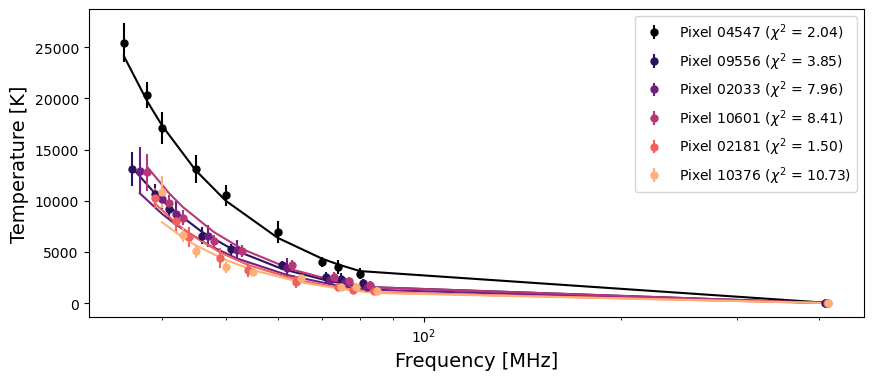

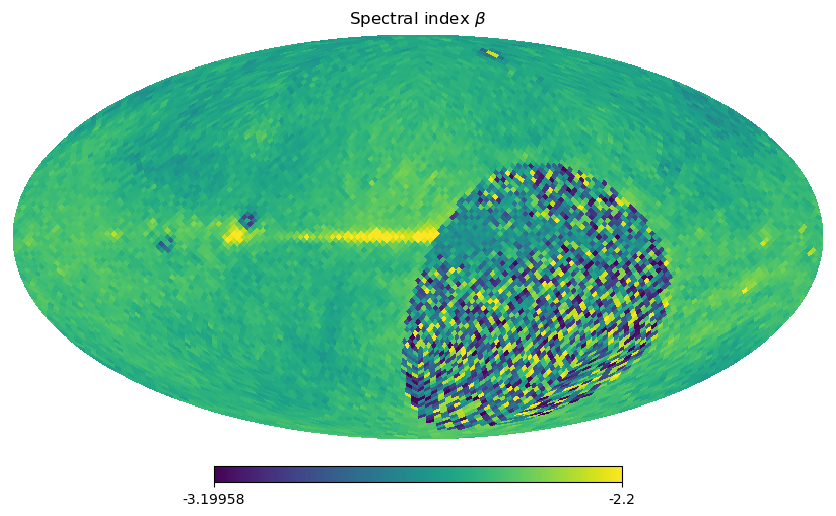

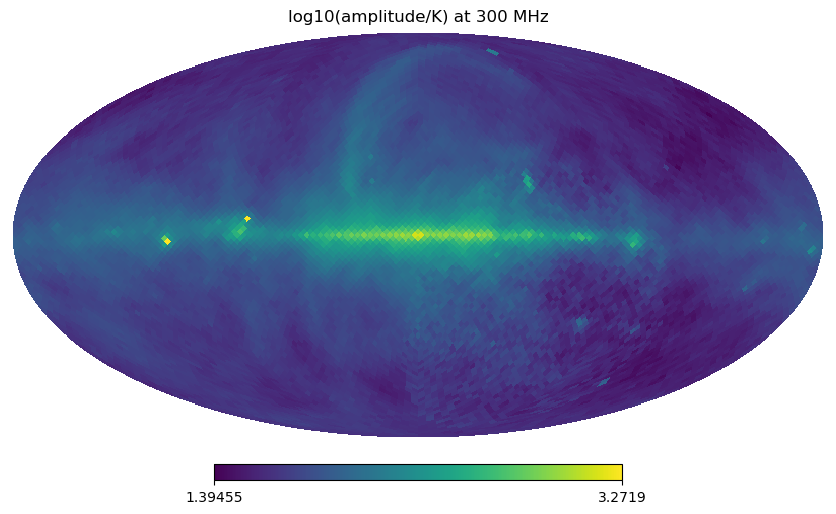

In [704]:
Nsamp = 6
np.random.seed(8)

for j, i in enumerate(np.random.randint(low=0, high=data_maps.shape[1], size=Nsamp)):
    
    # Get data points and std. dev.
    yy = data_maps[:,i]
    yy[np.where(np.abs(yy) > 1e10)] = 0.
    err = 1./np.sqrt(inv_noise_var[:,i])
    
    # Get projection operator
    proj = proj_fn(data_freqs, nu_ref=nu_ref, params=beta_samples[i,:])
    
    # Calculate chi^2
    chi2 = np.sum(inv_noise_var[:,i] * (yy - proj @ s[0,i,:])**2.)
    #print("chi^2 = %6.3f (pixel %d)" % (chi2, i))
    
    # Plot results
    colour = plt.cm.magma(j / Nsamp)
    #plt.errorbar(data_freqs+j, yy - proj @ s[0,i,:], yerr=err, marker='.', ls='none', color=colour, ms=10)
    plt.errorbar(data_freqs+j, yy, yerr=err, marker='.', ls='none', color=colour, ms=10, 
                 label="Pixel %05d ($\chi^2$ = %4.2f)" % (i, chi2))
    plt.plot(data_freqs+j, proj @ s[0,i,:], ls='solid', color=colour)
    #plt.plot(data_freqs, , color=colour)
    
plt.xscale('log')
plt.xlabel("Frequency [MHz]", fontsize=14)
plt.ylabel("Temperature [K]", fontsize=14)

plt.legend(loc='upper right')
#plt.yscale('log')
#plt.ylim((-100, 100))
plt.gcf().set_size_inches((10., 4.))

# Plot maps
hp.mollview(beta_samples[:,0], title=r"Spectral index $\beta$")

hp.mollview(np.log10(s[0,:,0]), title=r"log10(amplitude/K) at 300 MHz")